In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import datetime

Download past 2 years of ITC stock price 

In [2]:
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=2*365)
ticker = 'ITC.NS'
data = yf.download(ticker, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [25]:
print(data.head())

Price            Close        High         Low        Open    Volume
Ticker          ITC.NS      ITC.NS      ITC.NS      ITC.NS    ITC.NS
Date                                                                
2023-05-25  414.228729  415.449414  408.266234  410.285052  18204464
2023-05-26  416.529236  417.609051  412.679433  416.341429  12995706
2023-05-29  421.693573  424.228788  416.998699  417.843771  19826254
2023-05-30  428.891022  430.368659  420.406631  420.406631  18900002
2023-05-31  424.696472  430.892941  421.788910  428.319012  14272292


Prepare features and target (next day's log return)

In [26]:
features = data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
features['log_return'] = np.log(features['Close'] / features['Close'].shift(1))
features = features.dropna()  
print(features.head())

Price             Open        High         Low       Close    Volume  \
Ticker          ITC.NS      ITC.NS      ITC.NS      ITC.NS    ITC.NS   
Date                                                                   
2023-05-26  416.341429  417.609051  412.679433  416.529236  12995706   
2023-05-29  417.843771  424.228788  416.998699  421.693573  19826254   
2023-05-30  420.406631  430.368659  420.406631  428.891022  18900002   
2023-05-31  428.319012  430.892941  421.788910  424.696472  14272292   
2023-06-01  426.126428  426.126428  418.500004  419.167328   8803137   

Price      log_return  
Ticker                 
Date                   
2023-05-26   0.005538  
2023-05-29   0.012322  
2023-05-30   0.016924  
2023-05-31  -0.009828  
2023-06-01  -0.013105  


In [27]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'log_return']
X_all = features[feature_cols].values
y_all = features['log_return'].shift(-1).values
X_all = X_all[:-1] 

Standardize features

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

 Create sequences for LSTM

In [29]:
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(X_scaled)):
    X.append(X_scaled[i-sequence_length:i])
    y.append(y_all[i])
X, y = np.array(X), np.array(y)

Train-test split (80:20, sequential)

In [30]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build and Train LSTM model

In [31]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

C:\Users\pahwa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 229ms/step - loss: 0.0292 - val_loss: 0.0027
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0094 - val_loss: 9.0196e-04
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0049 - val_loss: 3.7108e-04
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0030 - val_loss: 2.8523e-04
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0018 - val_loss: 2.2479e-04
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0014 - val_loss: 2.4058e-04
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0017 - val_loss: 2.4192e-04
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0013 - val_loss: 2.6658e-04
Epoch 9/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0014 - val_loss: 1.8211e-04
Epoch 10/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 9.7561e-04 - val_loss: 1.4612e-04


Predict on test set

In [32]:
y_pred = model.predict(X_test)
print(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 493ms/step
[[ 0.01187592]
 [ 0.0076434 ]
 [ 0.00438255]
 [ 0.002036  ]
 [-0.0021128 ]
 [-0.00359587]
 [-0.00457076]
 [-0.00554374]
 [-0.00630989]
 [-0.0063574 ]
 [-0.0034866 ]
 [-0.00105265]
 [ 0.00073056]
 [-0.00112737]
 [-0.00945846]
 [-0.00815581]
 [-0.00582384]
 [-0.00191531]
 [ 0.00308801]
 [ 0.00725787]
 [ 0.0075443 ]
 [ 0.00682223]
 [ 0.00636488]
 [ 0.00515799]
 [ 0.0034524 ]
 [ 0.00108185]
 [-0.00125392]
 [-0.00153912]
 [-0.00480778]
 [-0.00432316]
 [-0.00353508]
 [-0.00290977]
 [-0.00386681]
 [-0.00588073]
 [-0.00187695]
 [-0.00152333]
 [ 0.00094191]
 [ 0.00055403]
 [ 0.00103031]
 [ 0.0016807 ]
 [ 0.00174383]
 [ 0.00313319]
 [ 0.00305665]
 [ 0.00222572]
 [ 0.00152709]
 [ 0.00125266]
 [ 0.00313532]
 [ 0.00418596]
 [ 0.00597566]
 [ 0.00551014]
 [ 0.00538183]
 [ 0.00558186]
 [ 0.00539656]
 [ 0.00461694]
 [ 0.00414733]
 [ 0.00238821]
 [ 0.00146416]
 [-0.00184064]
 [-0.00100402]
 [-0.00186026]
 [-0.00286507]
 [-0.0032895 ]
 [-0.00355857]
 [-0.00222401]
 

Evaluation and visualize

In [33]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.6f}")

Mean Absolute Error (MAE): 0.009357


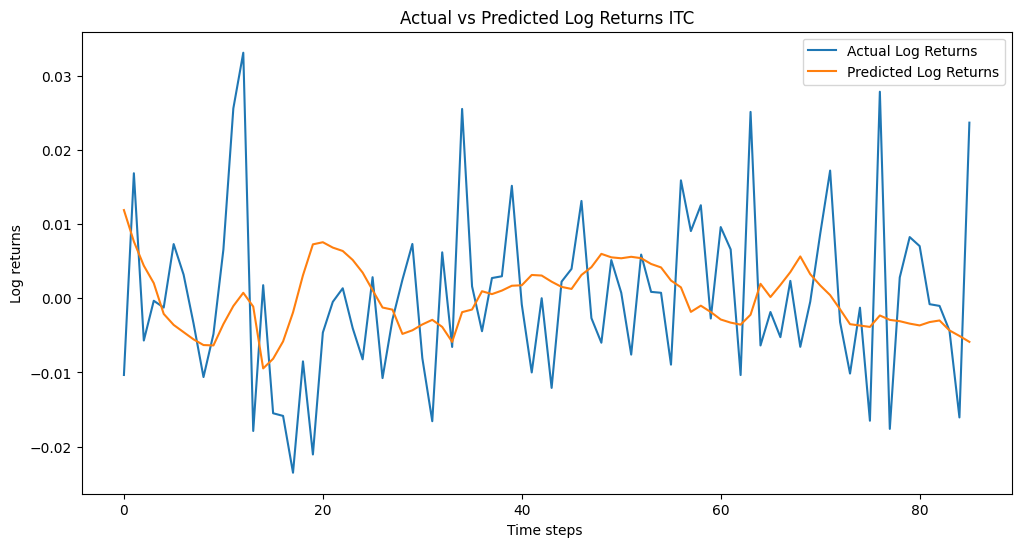

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Log Returns')
plt.plot(y_pred, label='Predicted Log Returns')
plt.xlabel('Time steps ')
plt.ylabel('Log returns')
plt.legend()
plt.title('Actual vs Predicted Log Returns ITC')
plt.show()